In [1]:
from tensorflow.python.client import device_lib
print(device_lib.list_local_devices())

[name: "/device:CPU:0"
device_type: "CPU"
memory_limit: 268435456
locality {
}
incarnation: 17886691950560306831
, name: "/device:XLA_CPU:0"
device_type: "XLA_CPU"
memory_limit: 17179869184
locality {
}
incarnation: 7809082297565334198
physical_device_desc: "device: XLA_CPU device"
, name: "/device:XLA_GPU:0"
device_type: "XLA_GPU"
memory_limit: 17179869184
locality {
}
incarnation: 4885225054825042637
physical_device_desc: "device: XLA_GPU device"
, name: "/device:GPU:0"
device_type: "GPU"
memory_limit: 11150726272
locality {
  bus_id: 1
  links {
  }
}
incarnation: 8451724154232807947
physical_device_desc: "device: 0, name: Tesla K80, pci bus id: 0000:00:04.0, compute capability: 3.7"
]


**(utilisez le GPU pour être rapide comme l'éclair !)**

# Apprenez une heuristique pour le Go

Dans ce TP noté, vous devrez déployer des methodes d'apprentissage automatique permettant d'évaluer la qualité de plateaux de GO.

Pour cela, vous disposerez de 41563 exemples de plateau de Go, tous générés par gnugo après quelques coups contre lui même avec un niveau de difficulté de 0. Par chaque plateau, nous avons lancé 100 matchs de gnugo contre lui même, toujours avec un niveau 0, et compté le nombre de victoires de noir et de blanc depuis ce plateau.

A noter, chaque "rollout" (un rollout et un déroulement possible du match depuis le plateau de référence) correspond à des mouvements choisis aléatoirement parmis les 10 meilleurs mouvements possibles, en biasant le choix aléatoire par la qualité prédite du mouvement par gnugo (les meilleurs mouvements ont une plus forte probabilité d'être tirés).

Les données dont vous disposez sont brutes. Ce sera à vous de proposer un format adéquat pour utiliser ces données en entrée de votre réseau neuronal. 

## Comment sera évalué votre modèle ?

Nous vous fournirons 6h avant la date de rendu un nouveau fichier contenant 1000 nouveaux exemples, qui ne contiendront pas les champs `black_wins`, `white_wins`, `black_points` et `white_points`. Vous devrez laisser, dans votre dépot de projet un fichier texte nommé `my_predictions.txt` ayant une prédiction par ligne (un simple flottant) qui donnera, dans le même ordre de la liste des exemples les scores que vous prédisez pour chacune des entrées du fichier que nous vous aurons donné. Il faudra laisser, dans votre feuille notebook (voir tout en dessous) la cellule Python qui aura créé ce fichier, pour que l'on puisse éventuellement refaire vos prédictions.

Bien entendu, vous nous rendrez également votre feuille jupyter **sous deux formats**, à la fois le fichier `.ipynb` et le fichier `.html` nous permettant de lire ce que vous avez fait, sans forcément relancer la feuille. Nous prendrons en compte les résultats obtenus sur les prédictions mais aussi le contenu de vos notebooks jupyter.

### Comment sera noté ce TP ?

Il s'agit d'un TP noté, donc il ne faudra pas y passer trop de temps. Nous attendons des prédictions correctes mais surtout des choix justifiés dans la feuille. Votre feuille notebook sera le plus important pour la notation (n'hésitez pas à mettre des cellules de texte pour expliquer pourquoi vous avez été amenés à faire certains choix). Ainsi, il serait bien d'avoir, par exemple, les données (graphiques ou autre) qui permettent de comprendre comment vous avez évité l'overfitting.

Le fichier de vos prédiction sera évalué en se basant sur la qualité de vos prédictions. Nous mesurerons par exemple le nombre d'exemples dont votre prédiction donnera la bonne valeur à 5%, 10%, 20%, 35%, 50% pour estimer sa qualité.


## Mise en route !

Voyons  comment lire les données


In [2]:
# Import du fichier d'exemples

def get_raw_data_go(data_to_predict, output):
    ''' Returns the set of samples from the local file or download it if it does not exists'''
    import gzip, os.path
    import json

    raw_samples_file = output

    if not os.path.isfile(raw_samples_file):
        print("File", raw_samples_file, "not found, I am downloading it...", end="")
        import urllib.request 
        urllib.request.urlretrieve (data_to_predict, output)
        print(" Done")

    with gzip.open(output) as fz:
        data = json.loads(fz.read().decode("utf-8"))
    return data

# Fonction telechargeant le fichier
def download(url,file):
  import os.path
  if not os.path.isfile(file):
        print("File", file, "not found, I am downloading it...", end="")
        import urllib.request 
        urllib.request.urlretrieve (url, file)
        print(" Done")


data = get_raw_data_go("https://www.labri.fr/perso/lsimon/ia-inge2/samples-9x9.json.gz","samples-9x9.json.gz")
print("We have", len(data),"examples")
N_EXAMPLES = len(data)

We have 41563 examples


## Compréhension des données de chaque entrée

Voici une description de chaque exemple

In [3]:
def summary_of_example(data, sample_nb):
    ''' Gives you some insights about a sample number'''
    sample = data[sample_nb]
    print("Sample", sample_nb)
    print()
    print("Données brutes en format JSON:", sample)
    print()
    print("The sample was obtained after", sample["depth"], "moves")
    print("The successive moves were", sample["list_of_moves"])
    print("After these moves and all the captures, there was black stones at the following position", sample["black_stones"])
    print("After these moves and all the captures, there was white stones at the following position", sample["white_stones"])
    print("Number of rollouts (gnugo games played against itself from this position):", sample["rollouts"])
    print("Over these", sample["rollouts"], "games, black won", sample["black_wins"], "times with", sample["black_points"], "total points over all this winning games")
    print("Over these", sample["rollouts"], "games, white won", sample["white_wins"], "times with", sample["white_points"], "total points over all this winning games")

summary_of_example(data,10)

Sample 10

Données brutes en format JSON: {'depth': 8, 'list_of_moves': ['C6', 'E7', 'C3', 'C8', 'E5', 'G3', 'B7', 'H7'], 'black_stones': ['B7', 'C6', 'E5', 'C3'], 'white_stones': ['C8', 'E7', 'H7', 'G3'], 'rollouts': 100, 'black_wins': 60, 'black_points': 876.0, 'white_wins': 40, 'white_points': 378.0}

The sample was obtained after 8 moves
The successive moves were ['C6', 'E7', 'C3', 'C8', 'E5', 'G3', 'B7', 'H7']
After these moves and all the captures, there was black stones at the following position ['B7', 'C6', 'E5', 'C3']
After these moves and all the captures, there was white stones at the following position ['C8', 'E7', 'H7', 'G3']
Number of rollouts (gnugo games played against itself from this position): 100
Over these 100 games, black won 60 times with 876.0 total points over all this winning games
Over these 100 games, white won 40 times with 378.0 total points over all this winning games


## Données en entrée et en sortie de votre modèle final

Même si en interne, votre modèle va manipuler des tenseurs en numpy, vous devrez construire une boite noire qui prendra en entrée les coordonnées des pierres noires et blanches et donnera le pourcentage de chance pour noir de gagner depuis cette position. 

Ainsi, pour l'exemple `i` :
- Vous prendez en entree `data[i]["black_stones"]` et `data[i]["white_stones"]`
- Vous devrez prédire simplement `data[i]["black_wins"]/data[i]["rollouts"]`

Encore une fois, **attention** : en interne, il faudra absolument construire vos données formattées en matrices numpy pour faire votre entrainement. On vous demande juste ici d'écrire comment vous faites ces transformations, pour comprendre ce que vous avez décidé de mettre en entrée du réseau.

Voici le modèle de la fonction qui pourra être appelée, au final :


In [0]:
# Ainsi, pour le rendu, en admettant que newdata soit le fichier json contenant les nouvelles données que 
# l'on vous donnera 24h avant la fin, vous pourrez construire le fichier resultat ainsi

def create_result_file(newdata):
    ''' Exemple de méthode permettant de générer le fichier de resultats demandés. '''
    resultat  = [position_predict(d["black_stones"], d["white_stones"]) for d in newdata]
    with open("my_predictions.txt", "w") as f:
         for p in resultat:
            f.write(str(p)+"\n")



The CDF curve shows that black has more chances to win, globally


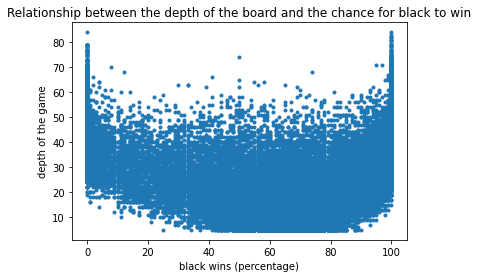

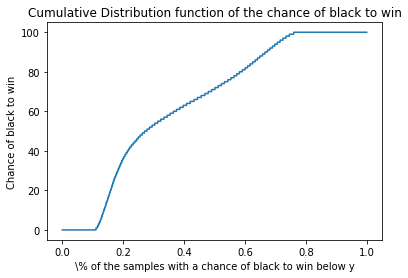

In [5]:
%matplotlib inline
import matplotlib.pyplot as plt

plt.title("Relationship between the depth of the board and the chance for black to win")
plt.plot([sample["black_wins"] for sample in data],[sample["depth"] for sample in data], '.')
plt.xlabel("black wins (percentage)")
plt.ylabel("depth of the game")


# Cumulative Distribution function of the chance of black to win
cdf_wins = sorted([sample["black_wins"] for sample in data])
plt.figure()
plt.plot([x/len(cdf_wins) for x in range(len(cdf_wins))], cdf_wins)
plt.title("Cumulative Distribution function of the chance of black to win")
plt.xlabel("\% of the samples with a chance of black to win below y")
plt.ylabel("Chance of black to win")
print("The CDF curve shows that black has more chances to win, globally")

# First steps: transform all the data into numpy arrays to feed your neural network

Advices:
- do not use only a 9x9 matrix as input. Use at least two planes to encode the board. One plane for black and one plane for white (typically with a 1 if there is a black stone for the first plane and with a 1 if there is a white stone for the second plane). The dimension of an input should be at least `[9,9,2]`.
- consider to enrich your dataset with all symmetries and rotations. You should be able to multiply the number of samples to consider: any rotation of the board should have the same score, right?
- what should happen on the score if you switch the colors? To know which player has to play next, you can check, for a sample, the parity of the length of the list `data[i]["list_of_moves"]` (an odd length list would mean that white is the next player. An even length list means that black has to play).
- work on enlarging and preparing your data only once. Once all you input data is setup as a big Numpy matrix, you may want to save it for speeding up everything. You can use, for instance `numpy.rot90()` and `numpy.flipud()` to generate all the symmetries



In [0]:
import numpy as np
from sklearn import model_selection

def name_to_coord(s):
    assert s != "PASS"
    indexLetters = {'A':0, 'B':1, 'C':2, 'D':3, 'E':4, 'F':5, 'G':6, 'H':7, 'J':8}

    col = indexLetters[s[0]]
    lin = int(s[1:]) - 1
    return col, lin

board_size = 9
num_classes = 2

X = np.zeros([len(data)*12,board_size,board_size,num_classes], dtype = int)
Y = np.zeros([len(data)*12,num_classes], dtype = float)

for i in range(len(data)):
        
    # Construction du board
    for white in data[i]['white_stones']:
        # On recupere la coordonnée
        (col, lin) = name_to_coord(white)
        # On l'ajoute dans le plateau
        X[i][col][lin][1] = 1    
    for black in data[i]['black_stones']:
        (col, lin) = name_to_coord(black)
        X[i][col][lin][0] = 1    
        
    temp = X[i]

    # Ajout des flips normaux
    X[i+N_EXAMPLES*1] = np.flipud(np.rot90(temp, 1, axes = (0,1)))
    X[i+N_EXAMPLES*2] = np.fliplr(np.rot90(temp, 1, axes = (0,1)))

    # Ajout des rotations et flips pour les plateaux equivalents

    # Rotation 90° + symetries
    X[i+N_EXAMPLES*3] = np.rot90(temp, 1, axes = (0,1))
    X[i+N_EXAMPLES*4] = np.flipud(np.rot90(temp, 1, axes = (0,1)))
    X[i+N_EXAMPLES*5] = np.fliplr(np.rot90(temp, 1, axes = (0,1)))
    X[i+N_EXAMPLES*6] = np.rot90(temp, 2, axes = (0,1))
    X[i+N_EXAMPLES*7] = np.flipud(np.rot90(temp, 2, axes = (0,1)))
    X[i+N_EXAMPLES*8] = np.fliplr(np.rot90(temp, 2, axes = (0,1)))
    X[i+N_EXAMPLES*9] = np.rot90(temp, 3, axes = (0,1))
    X[i+N_EXAMPLES*10] = np.flipud(np.rot90(temp, 3, axes = (0,1)))
    X[i+N_EXAMPLES*11] = np.fliplr(np.rot90(temp, 3, axes = (0,1)))
        
    # Remplissage de Y
    b_wins = data[i]['black_wins'] / data[i]['rollouts']
    w_wins = data[i]['white_wins'] / data[i]['rollouts']
    Y[i][0] = b_wins
    Y[i][1] = w_wins
    
    for r in range(12):
        Y[i+N_EXAMPLES*r][0] = b_wins
        Y[i+N_EXAMPLES*r][1] = w_wins

# Split test/apprentissage
X_train,X_test,Y_train,Y_test = model_selection.train_test_split(X,Y,test_size=0.33, shuffle = True)

**Nous avons donc nos matrices X et Y correspondant respectivement aux données d'entrée sous la forme (N\*8,9,9,2) et aux probabilités de victoire en tant que joueur noir et joueur blanc sous la forme (N\*8,2)** 

**Pour chaque plateau des données nous avons ajouté :**
- **le plateau en lui même, sa symétrie verticale et horizontale**
- **la rotation du plateau de 90° et ses symétries**
- **la rotation du plateau de 180° et ses symétries**
- **la rotation du plateau de 270° et ses symétries**

**Ce qui nous revient à un total de 8 plateaux ajoutés pour un seul en entrée. En effet, le GO étant un jeu de plateau sans "sens", nous pouvons gonfler nos données en effectuant ces modifications sans pour autant qu'elles aient un impact sur la probabilité de victoire des noirs ou des blancs mais en bénéficiant de l'augmentation de notre jeu de données final.**

**On pourrait ne pas ajouter les symétries des plateaux 180° et 270° dans la mesure où cela créera des doublons, en revanche, les résultats obtenus sur des prédictions sont moins bons (nous le montrons après), donc nous les gardons.**

**Nous aurions pu les gonfler encore plus en considérant le changement de couleur, cependant nous avons fait le choix de ne pas le faire dans la mesure où si le joueur noir (le premier joueur à jouer) adopte une stratégie offensive (si une telle stratégie existe, nous ne sommes pas assez forts au GO pour pouvoir le prétendre !) et le blanc défensive, si on inverse les couleurs, cela veut dire que le joueur blanc adoptera une stratégie défensive... en jouant en premier, ce qui n'a pas de sens.**

In [7]:
print(X.shape)
print(Y.shape)

print(X_train.shape)
print(X_test.shape)
print(Y_train.shape)
print(Y_test.shape)

(498756, 9, 9, 2)
(498756, 2)
(334166, 9, 9, 2)
(164590, 9, 9, 2)
(334166, 2)
(164590, 2)


# Second steps: build your neural network and train it

Don't forget to check overfitting, ...

*advices* :
- you need to test Dense and Conv2D layers (the best models may contain convolution layers=
- if you use convolution layers, be sure not to downsize your board. Applying a filter should keep the original size of the board (9x9), otherwise you would somehow forget the stones on the borders
- you will use like 33% of your input sample for validation. However, the final goal is to score new data that will be given in addition to the actual data. So, you should use the 33% splitting rule to set up your network architecture and, once you fixed it, you should train your final model on the whole set of data, crossing your fingers that it will generalize well.
- Warning: if you launch the fit function from keras more than once, it will not reset the weights and the biases of your neural network. It's good news because you can add more and more epochs to your model, but be careful about the training/test sets: each time you call fit() with validation_split set up to something like 0.33, it will choose a **new** partition of the samples. So you are breaking your validation/training partition! We advice you to use the `sklearn.model_selection.train_test_split()` method to split the set of examples just once and then use the parameter `validation_data` in the call for `fit()`.  Thus you will be able to call it multiple time.


In [0]:
import tensorflow.keras
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, Dropout, Activation, Flatten
from tensorflow.keras.layers import Conv2D, BatchNormalization
import tensorflow.keras.optimizers as optimizers

model_GO = Sequential([
    Conv2D(filters = 64,
           input_shape = (9,9,2),
           activation = 'relu',
           kernel_size = (5,5),
           padding = 'same',
           data_format = 'channels_last'),
    BatchNormalization(axis = 3),
    Conv2D(filters = 64,
           activation = 'relu',
           kernel_size = (5,5),
           padding = 'same',
           data_format = 'channels_last'),
    BatchNormalization(axis = 3),
    Conv2D(filters = 64,
           activation = 'relu',
           kernel_size = (5,5),
           padding = 'same',
           data_format = 'channels_last'),
    BatchNormalization(axis = 3),
    Flatten(data_format = 'channels_last'),
    Dropout(rate = 0.5),
    Dense(units = 32,
          activation='relu'),
    Dense(2, activation='softmax'),
])

model_GO.compile(loss='mae',
              optimizer='adam',
              metrics=['accuracy'])

**Comme nous pouvons le voir ici, nous avons créé notre réseau de neurones composé de 10 couches. Pour les premières couches, nous avons utilisé les couches ```Conv2D``` nous permettant de créer un noyau de convolution et avons utilisé la fonction d'activation ```ReLU``` dans la mesure où elle permet de ne pas saturer (contrairement à Sigmoïde et tanh). En effet, le gradient est toujours elevé (égal à 1) si le neurone est activé. Tant qu'il ne s'agit pas d'un neurone "mort", les mises à jour successices sont efficaces. Mais nous avons aussi utilisé cette fonction d'activation car elle est rapide à calculer. Cette fonction d'activation augment considérablement la convergence (des bons résultats très vite).**

**Comme nous avons organisé nos données sous la forme de l'```input_shape``` suivante : (9,9,2), et que nous voulons mettre nos prédictions dans la dernière composante de notre matrice, nous n'oublions pas d'indiquer ```channels_last``` dans le format des données.**

**Après chaque couche de convolution, et afin d'éviter l'overfitting, nous avons mis en place des couches de ```BatchNormalization```. Grâce à cette couche, nous allons normaliser la couche d'entrée en ajustant la fonction d'activation. Cela nous permet d'aller plus vite dans l'exécution des algorithmes de réseaux de neurones : la normalisation nous permet d'avoir moins de dépendances concernant le nombre de paramètres en entrée. Dans la mesure où le nombre de paramètre est variable, si l'on change le nombre de paramètres sur une couche durant la propagation ou la backpropagation, cela va impacter toutes les autres couches et nous coûter en temps d'apprentissage. De plus, cela permet d'éviter les minima locaux en étant moins dépendant de l'initialisation.**

**Après avoir fait 3 couches de ```Conv2D``` suivies à chaque fois d'une ```BatchNormalization```, nous aplatissons les données (couche ```Flatten```) et nous effectuons une couche ```Dropout``` nous permettant d'ignorer certains neurones durant la phase d'apprentissage (avec une fréquence de 0.5) à chaque étape de l'entraînement. Cette autre couche nous permet donc d'éviter le phénomène d'overfitting en plus des couches ```BatchNormalization``` précédentes.**

**Pour finir, les dernières couches ```Dense``` vont relier tous les neurones et avec la fonction d'activation ```softmax```, on pourra générer des probabilités de victoire selon la couleur des pions (résultat donné avec un biais) sous la forme : ```[black_win %,white_win %]```.**

In [9]:
model_GO.summary()

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d (Conv2D)              (None, 9, 9, 64)          3264      
_________________________________________________________________
batch_normalization (BatchNo (None, 9, 9, 64)          256       
_________________________________________________________________
conv2d_1 (Conv2D)            (None, 9, 9, 64)          102464    
_________________________________________________________________
batch_normalization_1 (Batch (None, 9, 9, 64)          256       
_________________________________________________________________
conv2d_2 (Conv2D)            (None, 9, 9, 64)          102464    
_________________________________________________________________
batch_normalization_2 (Batch (None, 9, 9, 64)          256       
_________________________________________________________________
flatten (Flatten)            (None, 5184)              0

**Nous avons un total de 374946 paramètres donc seulement 384 n'étant pas entraînables. Ce qui correspond à une miniscule partie de tout nos paramètres, et donc nous pouvons facilement faire évoluer notre réseau de neurones afin de le perfectionner.**

# Last step

Prepare your model to predict the set of new data to predict, you will have only 6 hours to push your predictions.

(may be you would like to express, when guessing the percentage of wins for blacks, that it should reflect the fact that this score should be the same for all the symmetries you considered)...

**Ici, nous allons entraîner notre modèle précédent sur 66% des données d'entrée avec un ```batch_size``` de 128 (correspond au nombre d'exemples utilisé pour estimer le gradient de la fonction de coût) et un nombre d'époques égal à 30. 
Comme nous l'avons dit précédemment, nous pouvons faire beaucoup d'époques dans la mesure où nous avons pris nos précautions concernant le phénomène d'overfitting. De fait, nous avons grandement réduit son apparition et nous pouvons donc nous entraîner convenablement.**



In [10]:
epochs = 30
batch_size = 128

model_GO.fit(X_train, Y_train,
          batch_size=batch_size,
          epochs=epochs,
          verbose=1,
          validation_data=(X_test, Y_test)
            )
score = model_GO.evaluate(X_test, Y_test, verbose=0)
print('Test loss:', score[0])
print('Test accuracy:', score[1])


Epoch 1/30
2611/2611 [==============================] - 34s 13ms/step - loss: 0.1377 - accuracy: 0.8407 - val_loss: 0.1119 - val_accuracy: 0.8700
Epoch 2/30
2611/2611 [==============================] - 34s 13ms/step - loss: 0.1118 - accuracy: 0.8697 - val_loss: 0.1057 - val_accuracy: 0.8714
Epoch 3/30
2611/2611 [==============================] - 34s 13ms/step - loss: 0.1050 - accuracy: 0.8777 - val_loss: 0.1049 - val_accuracy: 0.8764
Epoch 4/30
2611/2611 [==============================] - 34s 13ms/step - loss: 0.1004 - accuracy: 0.8820 - val_loss: 0.0997 - val_accuracy: 0.8823
Epoch 5/30
2611/2611 [==============================] - 34s 13ms/step - loss: 0.0973 - accuracy: 0.8861 - val_loss: 0.0915 - val_accuracy: 0.8927
Epoch 6/30
2611/2611 [==============================] - 34s 13ms/step - loss: 0.0953 - accuracy: 0.8885 - val_loss: 0.0920 - val_accuracy: 0.8909
Epoch 7/30
2611/2611 [==============================] - 34s 13ms/step - loss: 0.0928 - accuracy: 0.8905 - val_loss: 0.0983 -

**Une fois les 30 époques réalisées et le modèle perfectionné, nous pouvons voir que nous n'avons pas mis tant de temps que cela (encore faut-il utiliser comme accélération matérielle, le GPU !) : ~20s par époque pour une valeur de précision finale de 91% et une perte de seulement 8%**

**Nous avons donc de très bons résultats finaux et nous pouvons même voir que dès les premières époques (les 10 premières) on atteint rapidement les 90% de précision !**

In [11]:
model_GO.save('model_projet')

model_json = model_GO.to_json()
with open("model.json", "w") as json_file:
    json_file.write(model_json)
# serialize weights to HDF5
model_GO.save_weights("model.h5")
print("Saved model to disk")

Instructions for updating:
If using Keras pass *_constraint arguments to layers.
INFO:tensorflow:Assets written to: model_projet/assets
Saved model to disk


In [12]:
def position_predict(black_stones, white_stones):

    X = np.zeros([1,board_size,board_size,num_classes], dtype = int)

    # Construction du board
    for white in white_stones:
        # On recupere la coordonnée
        (col, lin) = name_to_coord(white)
        # On l'ajoute dans le plateauchaque
        X[0][col][lin][1] = 1    
    for black in black_stones:
        (col, lin) = name_to_coord(black)
        X[0][col][lin][0] = 1

    prediction = model_GO.predict(X)
    
    return prediction

# Par exemple, nous pourrons appeler votre prédiction ainsi
print("Prediction this sample:")
P = 40000
prediction = position_predict(data[P]["black_stones"], data[P]["white_stones"])
reality = np.array([data[P]["black_wins"]/data[P]["rollouts"],data[P]["white_wins"]/data[P]["rollouts"]])
print("You predicted", prediction, "and the actual target was", reality)

Prediction this sample:
You predicted [[0.8732632  0.12673682]] and the actual target was [0.78 0.22]


**Enfin, il suffit d'appeler la fonction ```position_predict``` et nous pourrons avoir la prédiction grâce à notre modèle de la valeur des probabilités de victoires pour le joueur noir et blanc.**

**Le code suivant va prédire les probabilités pour les plateaux de notre jeu de base; Attention, cela prend un peu de temps d'exécuter le code suivant (construire à chaque fois le plateau de jeu et prédire pour les 40000+ valeurs). Pas forcément utile à re-exécuter !**

In [13]:
diff = np.empty((len(data),2))
print(diff.shape)

# Prédire sur le jeu de données de base
'''
for d in range(len(data)):
    prediction = position_predict(data[d]["black_stones"], data[d]["white_stones"])
    reality = np.array([data[d]["black_wins"]/data[d]["rollouts"],data[d]["white_wins"]/data[d]["rollouts"]])
    diff[d] = prediction - reality
'''

(41563, 2)


'\nfor d in range(len(data)):\n    prediction = position_predict(data[d]["black_stones"], data[d]["white_stones"])\n    reality = np.array([data[d]["black_wins"]/data[d]["rollouts"],data[d]["white_wins"]/data[d]["rollouts"]])\n    diff[d] = prediction - reality\n'

In [14]:
'''
diff = np.absolute(diff)
plt.hist(diff[:,0],50, facecolor='g', alpha=0.75)
plt.xlabel('Valeur absolue de la différence des probas : valeur prédite - réelle valeur')
plt.ylabel('Nombres d\'échantillons')
plt.title('(NOIR) Histogramme des prédictions sur le jeu de données de base : 50 barres')
plt.grid(True)
plt.show()

plt.hist(diff[:,1],50, facecolor='g', alpha=0.75)
plt.xlabel('Valeur absolue de la différence des probas : valeur prédite - réelle valeur')
plt.ylabel('Nombres d\'échantillons')
plt.title('(BLANC) Histogramme des prédictions sur le jeu de données de base : 50 barres')
plt.grid(True)
plt.show()
'''

"\ndiff = np.absolute(diff)\nplt.hist(diff[:,0],50, facecolor='g', alpha=0.75)\nplt.xlabel('Valeur absolue de la différence des probas : valeur prédite - réelle valeur')\nplt.ylabel('Nombres d'échantillons')\nplt.title('(NOIR) Histogramme des prédictions sur le jeu de données de base : 50 barres')\nplt.grid(True)\nplt.show()\n\nplt.hist(diff[:,1],50, facecolor='g', alpha=0.75)\nplt.xlabel('Valeur absolue de la différence des probas : valeur prédite - réelle valeur')\nplt.ylabel('Nombres d'échantillons')\nplt.title('(BLANC) Histogramme des prédictions sur le jeu de données de base : 50 barres')\nplt.grid(True)\nplt.show()\n"

In [15]:
'''
plt.hist(diff[:,0],3, facecolor='g', alpha=0.75)
plt.xlabel('Valeur absolue de la différence : valeur prédite - réelle valeur')
plt.ylabel('Nombres d\'échantillons')
plt.title('(NOIR) Histogramme des prédictions sur le jeu de données de base : 3 barres')
plt.grid(True)
plt.show()

plt.hist(diff[:,1],3, facecolor='g', alpha=0.75)
plt.xlabel('Valeur absolue de la différence : valeur prédite - réelle valeur')
plt.ylabel('Nombres d\'échantillons')
plt.title('(BLANC) Histogramme des prédictions sur le jeu de données de base : 3 barres')
plt.grid(True)
plt.show()
'''

"\nplt.hist(diff[:,0],3, facecolor='g', alpha=0.75)\nplt.xlabel('Valeur absolue de la différence : valeur prédite - réelle valeur')\nplt.ylabel('Nombres d'échantillons')\nplt.title('(NOIR) Histogramme des prédictions sur le jeu de données de base : 3 barres')\nplt.grid(True)\nplt.show()\n\nplt.hist(diff[:,1],3, facecolor='g', alpha=0.75)\nplt.xlabel('Valeur absolue de la différence : valeur prédite - réelle valeur')\nplt.ylabel('Nombres d'échantillons')\nplt.title('(BLANC) Histogramme des prédictions sur le jeu de données de base : 3 barres')\nplt.grid(True)\nplt.show()\n"

**Comme nous l'avons précisé, il n'est pas la peine de réexécuter tout le code précédent permettant d'effectuer les prédictions sur les 40000+ données de base (très long dûû à la construction des plateaux).**

**Les résultats sont les suivants :**

![Texte alternatif…](https://i.imgur.com/CALbZ9L.png)

![Texte alternatif…](https://i.imgur.com/96RlOws.png)

**Comme nous pouvons le voir, sur le jeu de base, la majorité des probabilités de victoire est majoritairement bien prédite.**

---------------------------------------

In [16]:
print("Moyenne des écart (NOIR) : ", np.mean(diff[:,0])) 
print("Moyenne des écart (BLANC) : ", np.mean(diff[:,1])) 

Moyenne des écart (NOIR) :  nan
Moyenne des écart (BLANC) :  9.457596759230024e-05


**Comme nous pouvons le voir, sur les données de base, nous avons un écarts de moyenne de seulement 7%. Cependant, il s'agit des données de base. Quand on a utilisé le modèle sur les données de test la veille du rendu, nous avons obtenu ces résultats :**

```
En dessous de 1% : 1
En dessous de 5% : 9
En dessous de 10% : 34
En dessous de 20% : 46
En dessous de 50% : 71
La vraie accuracy vaut : 0.6390679131507873
```

![Résultats sur le jeu de données de test](https://i.imgur.com/sbKFRcr.png)



**Les résultats des données ne sont pas aussi satisfaisants qu'auparavant. Malgré nos efforts afin de réduire l'overfitting (couches ```BatchNormalization```, couche ```Dropout```, réduction des époques à 30 initialement à 50), le phénomène est bien présent ! Une explication pourrait être à cause de notre jeu de données de base : en effet, nous avons des doublons (nous avons utilisé 12 symétries au lieu de 8 seulement).**
**Cependant, comme le montre l'image suivante correspondant aux prédictions d'un jeu de test de 100 données avec augmentation du jeu de données avec 8 symétries, Dropout 0.25 et 30 époques, nous n'avons une bonne accuracy du tout :**
```
En dessous de 1% : 14
En dessous de 5% : 17
En dessous de 10% : 20
En dessous de 20% : 22
En dessous de 50% : 35
La vraie accuracy vaut : 0.4104
```
![8 symétries, c'est pas fou](https://i.imgur.com/9I6hxS9.png)

**De plus, nous aurions pu pour améliorer notre modèle, ne pas traiter seulement les plateaux un par un, mais traiter tous les plateaux égaux (un plateau et ses symétries équivalentes) et passer ces plateaux au réseau de neurones, et pourquoi pas même ajouter la profondeur du plateau dans le réseau.**

**En effet, c'est ce que fait AlphaGo !**

----------------------------

#**PARTIE PREDICTION DONNÉES**

In [26]:
# Importer les données à tester
# ------------ CHANGER ICI LES URLS -----------------
data_url = "https://www.labri.fr/perso/lsimon/ia-inge2/positions-to-evaluate-9x9.json.gz"
data_to_predict = "to_predict.json.gz"

data_url_results = "https://www.labri.fr/perso/lsimon/ia-inge2/positions-to-evaluate-9x9-attempt.results.txt"
data_results = "results.txt"

to_predict = get_raw_data_go(data_url,data_to_predict)

'''
download(data_url_results,data_results)
# Récuperer les résults
with open("results.txt") as f:
    txt = f.readlines()
results = [float(x.strip()) for x in txt]
'''

File to_predict.json.gz not found, I am downloading it... Done


'\ndownload(data_url_results,data_results)\n# Récuperer les résults\nwith open("results.txt") as f:\n    txt = f.readlines()\nresults = [float(x.strip()) for x in txt]\n'

En dessous de 1% : 20
En dessous de 5% : 24
En dessous de 10% : 26
En dessous de 20% : 36
En dessous de 50% : 65
La vraie accuracy vaut : 0.5896026702880859


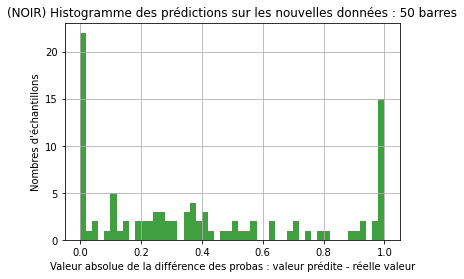

In [24]:
def do_mean_detailed(prediction,reality) :
    final = np.empty((len(prediction)))
    
    mean = 0
    div = 0
    un = 0
    cinq = 0
    dix = 0
    vingt = 0
    cinquante = 0

    for i in range(len(prediction)):
        final[i] = abs(prediction[0] - reality[i])
        ecart = final[i]

        if(ecart < 0.01):
            un += 1
        if(ecart < 0.05):
            cinq += 1
        if(ecart < 0.10):
            dix += 1
        if(ecart < 0.20):
            vingt += 1
        if(ecart <0.5):
            cinquante += 1

    print("En dessous de 1% :",un)
    print("En dessous de 5% :",cinq)
    print("En dessous de 10% :",dix) 
    print("En dessous de 20% :",vingt)
    print("En dessous de 50% :",cinquante)

    mean = np.mean(final)
    print("La vraie accuracy vaut : {}".format(1-mean))

    return mean, final, predictions

'''
# Predire les données
predictions = np.empty(len(to_predict))

for t in range(len(to_predict)):
  predictions[t] = position_predict(to_predict[t]['black_stones'], to_predict[t]['white_stones'])[0][0]

# Voir différences avec les résultats des tests (SEULEMENT POUR NOUS)
mean, final, predictions = do_mean_detailed(predictions, results)
plt.hist(final,50, facecolor='g', alpha=0.75)
plt.xlabel('Valeur absolue de la différence des probas : valeur prédite - réelle valeur')
plt.ylabel('Nombres d\'échantillons')
plt.title('(NOIR) Histogramme des prédictions sur les nouvelles données : 50 barres')
plt.grid(True)
plt.show()
'''

**Ici, nous allons écrire dans ```my_predictions.txt``` nos prédictions selon les nouvelles données**

In [0]:
# Predire les données
predictions = np.empty(len(to_predict))

# Remplir le tableau de prédictions
for t in range(len(to_predict)):
  # Comme nous souhaitons seulement les prédictions sur le % de victoire pour le joueur noir, on prend la première composante
  predictions[t] = position_predict(to_predict[t]['black_stones'], to_predict[t]['white_stones'])[0][0]

In [0]:
with open("my_predictions.txt", "w") as f:
     for p in predictions:
        f.write(str(p)+"\n")